# N.8. : Segmentation des images

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
%matplotlib inline

In [2]:
def compute_hist(img):
    """
    Parameter
    ---------
    img : Numpy Array (HxW)
    Returns
    -------
    output: Numpy Array
        256d-array where the ith element corresponds to
        the number of pixels.
    """
    output = np.zeros(256, dtype=np.int32)
    for i in range(len(output)):
        output[i] = len(img[img==i])
    return output

## I. Segmentation d'images par seuillage d'histogramme (Binarisation)

### Objectif

Etude d’une méthode simple l’évaluation de seuil pour la binarisation d’une image à partir du seuil choisi de manière aléatoire.

### Algorithme

1. Choisir un seuil S de manière aléatoire (compris entre $0$ et $255$). Ainsi, les intensités inférieures à $S$ appartiennent au groupe 1 et les intensités supérieures appartiennent au groupe 2.

2. Calculer la moyenne de chacun des deux groupes de pixels $S_{1}$ et $S_{2}$ grâce à la répartition des pixels donnée par l’histogramme de l’image.

3. Calculer $S = \frac{S_{1}+S_{2}}{2}$

4. Répéter les étapes 2 et 3 jusqu'à ce que S soit constant.

### Travail proposé

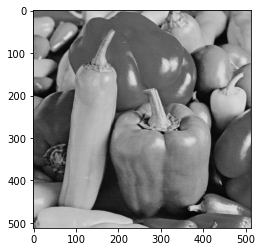

In [3]:
img = cv2.imread("./data/pepper.bmp")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap=plt.cm.gray, vmin = 0, vmax = 255)

**1.** Calculer l’histogramme de l’image « pepper.bmp » proposée.

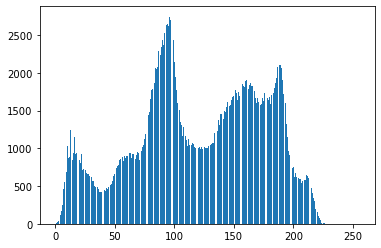

In [4]:
hist = compute_hist(img)
plt.bar(np.array([i for i in range(256)]), hist)
plt.show()

**2.** Implémenter l'algorithme de seuillage proposé et vérifier la convergence de celui-ci.

In [5]:
def find_threshold(img):
    """ TODO
    """
    previous = -1
    threshold = np.random.randint(0, 255)
    n_iter = 0
    while previous!=threshold and n_iter < 100:
        previous = threshold
        pixels = np.sort(img.flatten())
        group1 = pixels[pixels < threshold]
        group2 = pixels[pixels >= threshold]

        s1 = group1.mean()
        s2 = group2.mean()

        threshold = (s1+s2)/2
        n_iter += 1

    return (threshold, n_iter)

In [6]:
np.random.seed(0)
threshold, n_iter = find_threshold(img)
print(f"Obtained threshold: {threshold:.05} in {n_iter} iterations.")

Obtained threshold: 120.05 in 7 iterations.


**3.** Seuiller l'image de deux manières différenes:

* Proposition 1 : $Pixel(i,j)= \begin{cases} 0, & \mbox{si } Pixel(i,j) < S \\ 255, & \mbox{sinon.}\end{cases}$

* Proposition 2 : $Pixel(i,j)= \begin{cases} S_{1}, & \mbox{si } Pixel(i,j) < S \\ S_{2}, & \mbox{sinon.}\end{cases}$

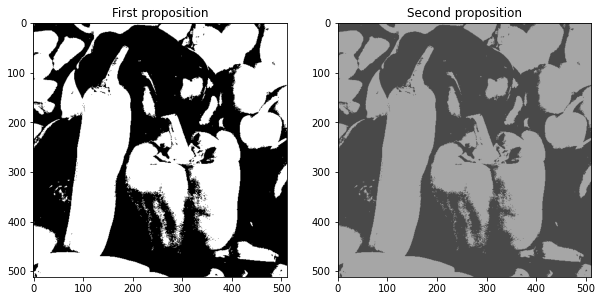

In [7]:
dst1 = img.copy()
dst2 = img.copy()

# 1st proposition
dst1[dst1 < threshold] = 0
dst1[dst1 >= threshold] = 255
# 2nd proposition
s1 = dst2[dst2 < threshold].mean()
s2 = dst2[dst2 >= threshold].mean()
dst2[dst2 < threshold] = s1
dst2[dst2 >= threshold] = s2

fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].set_title("First proposition")
axs[0].imshow(dst1, cmap=plt.cm.gray, vmin = 0, vmax = 255)
axs[1].set_title("Second proposition")
axs[1].imshow(dst2, cmap=plt.cm.gray, vmin = 0, vmax = 255)

## II. Segmentation d'images grâce à l'algorithme des K-means

### Objectif

Ce projet propose de segmenter une image grâce à l’algorithme des k-means.

### Algorithme

1. Choisir le nombre de classes ($K$ classes par exemple).

2. Choisir de manière aléatoire les moyennes des $K$ classes et les ranger dans un vecteur par ordre croissant.

3. Affecter pour chaque intensité $i$ allant de $0$ à $255$ de l'histogramme, la classe ayant la moyenne la plus proche de cette intensité $i$ :

$$
c(i)=min_{k \in [1,K]} (|i-m_{k}|) \\
\mbox{avec } m_{k} \mbox{ la moyenne de la } k^{ème} \mbox{ classe.}
$$

4. Calculer la moyenne de chaque nouvelle classe.

5. Répéter les étapes 3 et 4 jusqu'à convergence de l'algorithme.

### Travail proposé

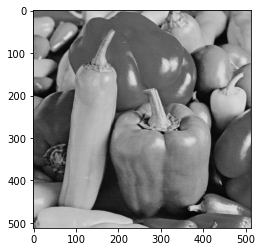

In [8]:
img = cv2.imread("./data/pepper.bmp")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap=plt.cm.gray, vmin = 0, vmax = 255)

**1.** Calculer l'histogramme de l'image « pepper.bmp » proposée.

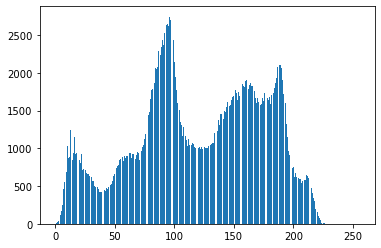

In [9]:
hist = compute_hist(img)
plt.bar(np.array([i for i in range(256)]), hist)
plt.show()

**2.** Implémenter l'algorithme de k-means proposé et vérifier la convergence de celui-ci.

In [10]:
def kmeans(src, k):
    """ TODO
    """
    means = np.sort(np.rint(np.random.rand(k)*(src.max()-src.min())+src.min()))
    previous = np.ones(k)-1
    n_iter = 0

    while not np.equal(previous, means).prod():
        previous = np.copy(means)
        dst = src.copy()
        for i in range(k):
            # those boundaries assume that 'previous' array is sorted
            upper = max(previous[i:i+2].mean(), 255 if i==k-1 else 0)
            lower = min(1,i)*previous[max(i-1, 0):i+1].mean()

            group = dst[np.logical_and(lower<=dst,dst<=upper)]
            dst[np.logical_and(lower<=dst,dst<=upper)] = i

            if len(group)>0:
                means[i]=group.mean()
        # rounds means to integers
        means = np.rint(means)
        n_iter += 1
    
    return(dst, means, n_iter)


Obtained means: [ 35.  93. 147. 187.] in 11 iterations.


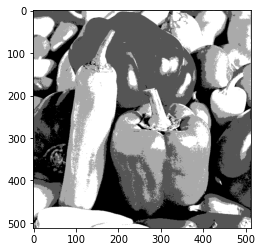

In [11]:
np.random.seed(0)
dst, means, n_iter = kmeans(img, 4)
print(f"Obtained means: {means} in {n_iter} iterations.")
plt.imshow(dst, cmap=plt.cm.gray)

**3.** Segmenter l'image en affectant à chaque pixel, la moyenne de la classe auquel il appartient. 

Execution lasted : 0.527s


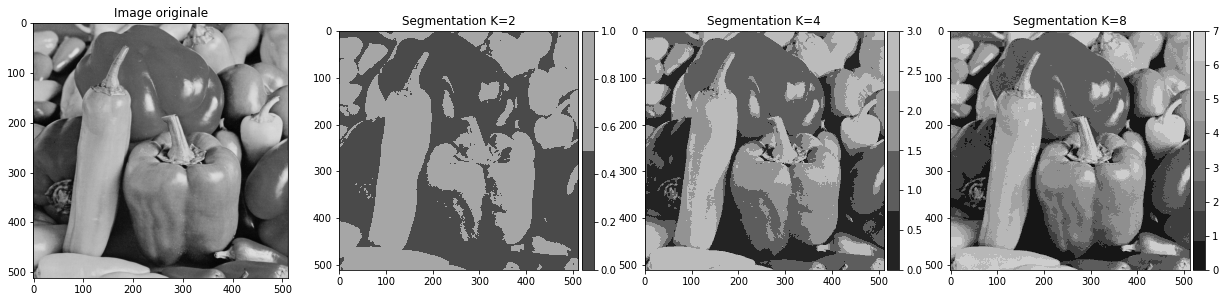

In [12]:
start = time.time()
fig, axs = plt.subplots(1, 4, figsize=(21,10))

axs[0].set_title("Image originale")
axs[0].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=255)

for n, k in enumerate([2, 4, 8]):
    np.random.seed(0)
    dst, means, n_iter = kmeans(img, k)
    colors = np.array([[value, value, value] for value in means])
    axs[n+1].set_title(f"Segmentation K={k}")
    cs = axs[n+1].imshow(dst, cmap=mlp.colors.ListedColormap(colors/255))

    divider = make_axes_locatable(axs[n+1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cs, cax=cax)

end = time.time()
print(f"Execution lasted : {end - start:.03}s")
plt.show()

## Questions avancées

**A.1.** Segmentation par seuillage de l’histogramme et par Kmeans des images de poumons affecté et non affecté.

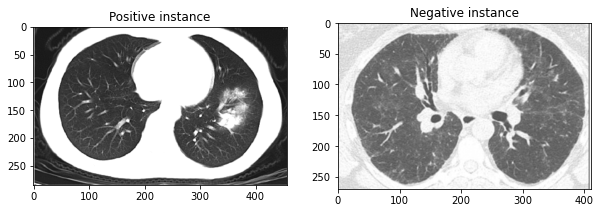

In [13]:
img_pos = cv2.imread("./data/CT_COVID.png")
img_pos = cv2.cvtColor(img_pos, cv2.COLOR_BGR2GRAY)

img_neg = cv2.imread("./data/CT_NonCOVID.jpg")
img_neg = cv2.cvtColor(img_neg, cv2.COLOR_BGR2GRAY)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].set_title("Positive instance")
axs[0].imshow(img_pos, cmap=plt.cm.gray, vmin=0, vmax=255)
axs[1].set_title("Negative instance")
axs[1].imshow(img_neg, cmap=plt.cm.gray, vmin=0, vmax=255)

*Segmentation par seuillage de l'historgramme*

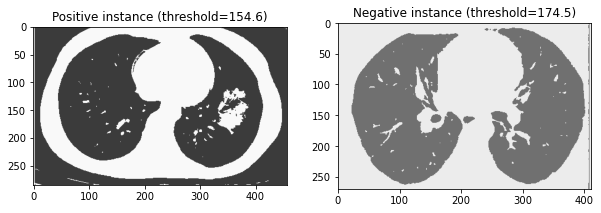

In [14]:
np.random.seed(0)
thresh_pos, _ = find_threshold(img_pos)
dst1 = img_pos.copy()
s1 = dst1[dst1 < thresh_pos].mean()
s2 = dst1[dst1 >= thresh_pos].mean()
dst1[dst1 < thresh_pos] = s1
dst1[dst1 >= thresh_pos] = s2

np.random.seed(0)
thresh_neg, _ = find_threshold(img_neg)
dst2 = img_neg.copy()
s1 = dst2[dst2 < thresh_neg].mean()
s2 = dst2[dst2 >= thresh_neg].mean()
dst2[dst2 < thresh_neg] = s1
dst2[dst2 >= thresh_neg] = s2

fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].set_title(f"Positive instance (threshold={thresh_pos:0.04})")
axs[0].imshow(dst1, cmap=plt.cm.gray, vmin=0, vmax=255)
axs[1].set_title(f"Negative instance (threshold={thresh_neg:0.04})")
axs[1].imshow(dst2, cmap=plt.cm.gray, vmin=0, vmax=255)

*Segmentation par Kmeans*

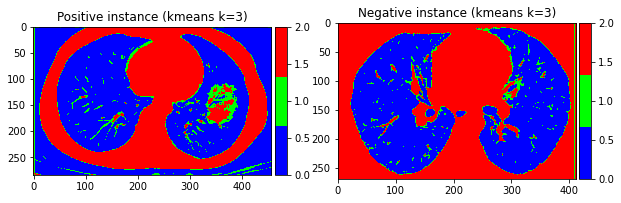

In [15]:
colors_3 = [
    (0, 0, 1),
    (0, 1, 0),
    (1, 0, 0),
]

colors_4 = [
    (0, 0, 1),
    (0, 1, 0),
    (1, 0, 0),
    (0, 1, 1)
]

colors_6 = [
    (0, 0, 1),
    (0, 1, 0),
    (1, 0, 0),
    (0, 1, 1),
    (1, 0, 1),
    (1, 1, 0),
]

cmaps = {3: colors_3, 4: colors_4, 6: colors_6}

k = 3
colors = cmaps[k]

np.random.seed(0)
dst_pos = img_pos.copy()
dst3, means_pos, n_iter_pos = kmeans(dst_pos, 3)

np.random.seed(0)
dst_neg = img_neg.copy()
dst4, means_neg, n_iter_neg = kmeans(dst_neg, 3)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].set_title(f"Positive instance (kmeans k={k})")
cs1 = axs[0].imshow(dst3, cmap=mlp.colors.ListedColormap(colors_3))
divider = make_axes_locatable(axs[0])
cax1 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(cs1, cax=cax1)

axs[1].set_title(f"Negative instance (kmeans k={k})")
cs2 = axs[1].imshow(dst4, cmap=mlp.colors.ListedColormap(colors_3))
divider = make_axes_locatable(axs[1])
cax2 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(cs2, cax=cax2)

**A.2.** Classification par Kmeans des images couleur : modifier l'algorithme de K-means pour classer les nuages de points.

(105, 79, 3)


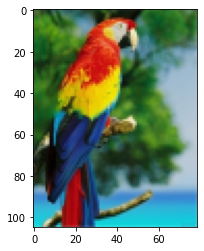

In [16]:
img = cv2.imread("./data/perroquet_couleur.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
scale_percent = 15
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
img = np.asarray(img, dtype=np.uint8)
print(img.shape)
plt.imshow(img)

In [17]:
def find_closest_mean(src, means):
    """ Given an image finds for each pixel the index of the closest mean
    in the means attribute.
    Parameters
    ----------
    src: Numpy Array
        An image (H, W, C).
    means: Numpy Array
        A vector containing the means (N, C) with N the number of means.
    Returns
    -------
    Numpy Array
    """
    tmp = np.array([np.linalg.norm(src-mean, axis=2) for mean in means])
    
    output = np.argmin(tmp, axis=0)

    return output
        

In [18]:
def kmeans_color(src, k):
    """
    Parameters
    ----------
    src: Numpy Array
        An image (H, W, C).
    k: int
        K parameter in K-means algorithm, sets the number of cluster.
    Returns
    -------
    Numpy Array
        Mean of each cluster.
    int
        Number of iterations.
    """
    means = np.rint(np.random.rand(k, 3)*255)
    previous = np.ones((k, 3))-1
    n_iter = 0
    
    while not np.equal(previous, means).prod() and n_iter < 100:
        previous = np.copy(means)
        affectations = find_closest_mean(src, previous)
        for i in range(k):
            group = src[affectations == i]

            if len(group)>0:
                means[i]=np.mean(group, axis=0)

        # rounds means to integers
        means = np.rint(means)
        n_iter += 1

    dst = find_closest_mean(src, previous)
    return(means, n_iter, dst)

Obtained 4-means in 17 iterations.
Obtained 8-means in 23 iterations.
Obtained 32-means in 38 iterations.
Execution lasted : 0.743s


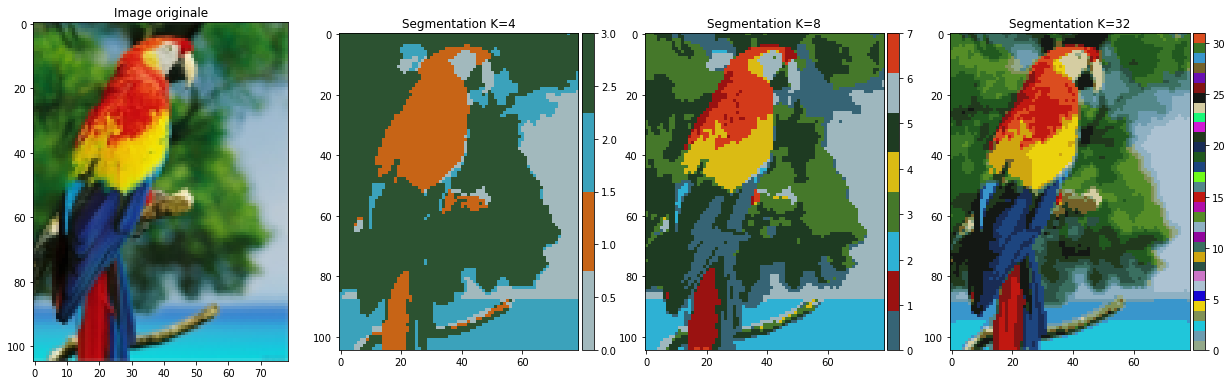

In [19]:
start = time.time()
fig, axs = plt.subplots(1, 4, figsize=(21, 10))

axs[0].set_title("Image originale")
axs[0].imshow(img)

for i, k in enumerate([4, 8, 32]):
    np.random.seed(0)
    means, n_iter, dst = kmeans_color(img, k)
    print(f"Obtained {k}-means in {n_iter} iterations.")
    axs[i+1].set_title(f"Segmentation K={k}")
    cs = axs[i+1].imshow(dst, mlp.colors.ListedColormap(means/255))

    divider = make_axes_locatable(axs[i+1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cs, cax=cax)
end = time.time()
print(f"Execution lasted : {end - start:.03}s")
plt.show()